Epoch 1, Loss: 164.8314
Epoch 2, Loss: 121.5104
Epoch 3, Loss: 114.5233
Epoch 4, Loss: 111.5767
Epoch 5, Loss: 109.8417


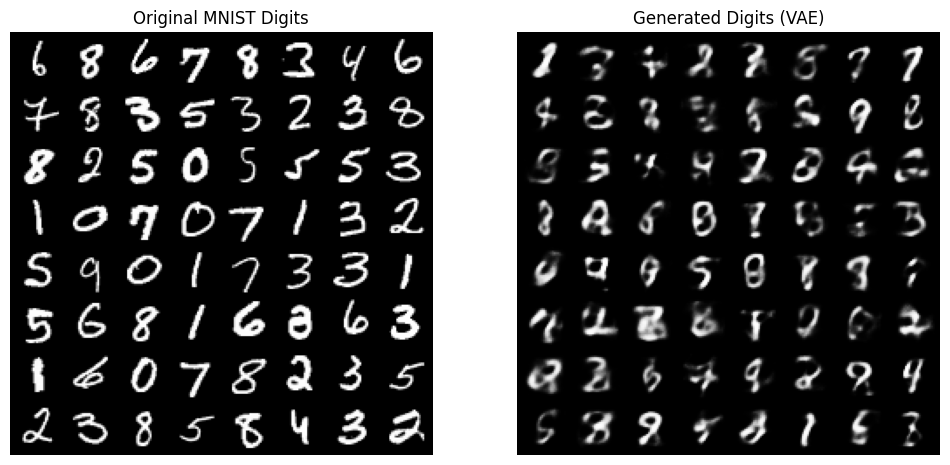

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt

# デバイス設定
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# VAEモデル定義
class VAE(nn.Module):
    def __init__(self, latent_dim=20):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(28*28, 400)
        self.fc21 = nn.Linear(400, latent_dim)  # 平均
        self.fc22 = nn.Linear(400, latent_dim)  # 分散
        self.fc3 = nn.Linear(latent_dim, 400)
        self.fc4 = nn.Linear(400, 28*28)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 28*28))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# モデル・オプティマイザ
latent_dim = 20
model = VAE(latent_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# MNISTデータ
transform = transforms.ToTensor()
dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

# 損失関数
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 28*28), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# 学習（簡易版）
epochs = 5
model.train()
for epoch in range(epochs):
    total_loss = 0
    for data, _ in dataloader:
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {total_loss / len(dataset):.4f}')

# ---- 元画像サンプル取得 ----
sample_imgs, _ = next(iter(dataloader))
sample_imgs = sample_imgs[:64]  # 64枚だけ
save_image(sample_imgs, 'original_digits.png')

# ---- 潜在変数から生成 ----
model.eval()
with torch.no_grad():
    z = torch.randn(64, latent_dim).to(device)
    gen_imgs = model.decode(z).cpu().view(64, 1, 28, 28)
    save_image(gen_imgs, 'vae_generated_digits.png')

# ---- 画像表示（元画像 vs 生成画像）----
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(torchvision.utils.make_grid(sample_imgs, nrow=8).permute(1, 2, 0))
axes[0].set_title('Original MNIST Digits')
axes[0].axis('off')
axes[1].imshow(torchvision.utils.make_grid(gen_imgs, nrow=8).permute(1, 2, 0))
axes[1].set_title('Generated Digits (VAE)')
axes[1].axis('off')
plt.show()
